# <p style="background-color:coral;font-family:newtimeroman;font-size:150%;color:white;text-align:center;border-radius:20px 20px;"><b>Cats & Dogs Classification with Pytorch from Scratch</b></p>

![](https://github.com/TirendazAcademy/End-to-End-Deep-Learning-Projects/blob/main/image_classification_pytorch_comet/Images/images/dog-cat.png?raw=true)




This notebook walks you through how to build a CNN model for image classification and predict data using this model with PyTorch.

### What is Image Classification?

![](https://editor.analyticsvidhya.com/uploads/59954intro%20to%20CNN.JPG)

Image classification is the task of assigning a label or class to an input image based on its content. This is typically done using machine learning algorithms that have been trained on a dataset of labeled images. Let's take a look at what we'll learn in this tutorial.

<b>*Table of contents:*</b>
<ul>
<li><a href="#Loading">Loading the dataset</a></li>  
<li><a href="#Understanding">Understanding the dataset</a></li>         
<li><a href="#Transforming-data">Transforming data</a></li>
<li><a href="#Loading-image-data">Loading image data</a></li>
<li><a href="#Model-building">Model building</a></li>
<li><a href="#Prediction">Make a prediction</a></li>
</ul>

In [9]:
# Install required packages
!pip install boto3 awscli sagemaker
!pip install torch torchvision
!pip install pandas numpy matplotlib seaborn
!pip install torchinfo
!pip install pillow
!pip install torch
!pip install torchsummary
!pip install gdown

In [6]:
import torch
from torch import nn
from torchsummary import summary
# Note: this notebook requires torch >= 1.10.0
torch.__version__

'2.6.0+cu124'

In [7]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

<a id="Loading"></a>
# <p style="background-color:coral;font-family:newtimeroman;font-size:150%;color:white;text-align:center;border-radius:20px 20px;"><b>1. Loading the Dataset</b></p>

The dataset we will use for this tutorial is the cat and dog dataset, which contains images of cats and dogs. Let's take a look at the files in the dataset folder. To do this, let me create a function.

In [10]:
import os
import gdown
import zipfile
import pandas as pd
import numpy as np

In [18]:
import os
zip_file_path = os.path.abspath("Ik/NLP/training_set-20240919T083719Z-001.zip")
if os.path.exists(zip_file_path):
    with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
        zip_ref.extractall(dataset_path)

In [29]:
from zipfile import ZipFile

# Open and extract in one step
ZipFile("training_set-20240919T083719Z-001.zip").extractall("dataset")
ZipFile("test_set-20240919T083718Z-001.zip").extractall("dataset")

In [30]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

image_path = "dataset"
walk_through_dir(image_path)

There are 2 directories and 0 images in 'dataset'.
There are 1 directories and 0 images in 'dataset/training_set'.
There are 2 directories and 0 images in 'dataset/training_set/training_set'.
There are 0 directories and 4001 images in 'dataset/training_set/training_set/cats'.
There are 0 directories and 4016 images in 'dataset/training_set/training_set/dogs'.
There are 1 directories and 0 images in 'dataset/test_set'.
There are 2 directories and 0 images in 'dataset/test_set/test_set'.
There are 0 directories and 1012 images in 'dataset/test_set/test_set/cats'.
There are 0 directories and 1013 images in 'dataset/test_set/test_set/dogs'.


Nice! We saw the files in the dataset folder. Now let's create train and testing paths:

In [31]:
train_dir = "dataset/training_set/training_set"
test_dir = "dataset/test_set/test_set"
train_dir, test_dir

('dataset/training_set/training_set', 'dataset/test_set/test_set')

<a id="Understanding"></a>
# <p style="background-color:coral;font-family:newtimeroman;font-size:150%;color:white;text-align:center;border-radius:20px 20px;"><b>2. Understanding the Dataset</b></p>

It is important to understand the dataset for deep learning analysis because the dataset is the foundation of any machine learning or deep learning model. A deep learning model can only be as good as the data it is trained on, and a poor understanding of the dataset can lead to poor model performance or even bias. Now let's take a look at an image in the dataset.

In [32]:
import random
from PIL import Image
import glob
from pathlib import Path

Random image path: dataset/test_set/test_set/cats/cat.4526.jpg
Image class: cats
Image height: 363
Image width: 499


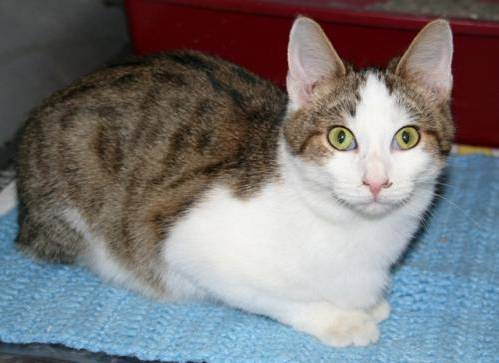

In [36]:


# Set seed
#random.seed(42)

# 1. Get all image paths (* means "any combination")
image_path_list= glob.glob(f"{image_path}/*/*/*/*.jpg")

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = Path(random_image_path).parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

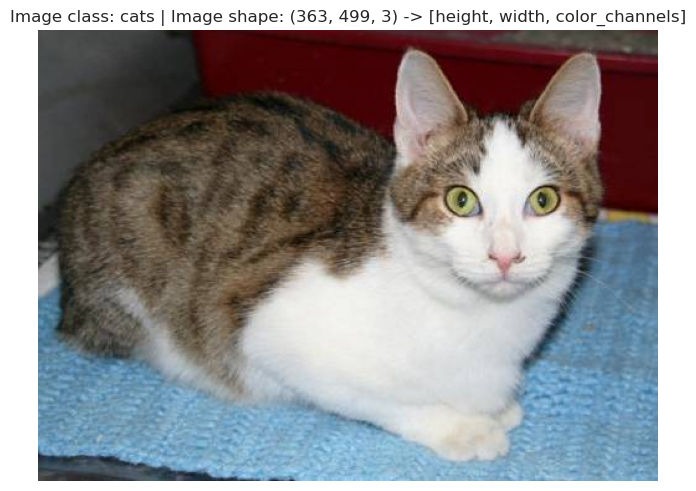

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

<a id="Transforming-data"></a>
# <p style="background-color:coral;font-family:newtimeroman;font-size:150%;color:white;text-align:center;border-radius:20px 20px;"><b>3. Transforming Data</b></p>

Transforming data, also known as preprocessing, is an important step in deep learning analysis because it can help to improve the performance of the model and reduce the risk of bias. Let's play with the images a bit with the `transform` method.

In [38]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)

# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to IMAGE_SIZE xIMAGE_SIZE
    transforms.Resize(size=IMAGE_SIZE),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

To understand how to transform the images, let's use data visualization. To do this, I'm going to craete a function named plot_transformed_images.

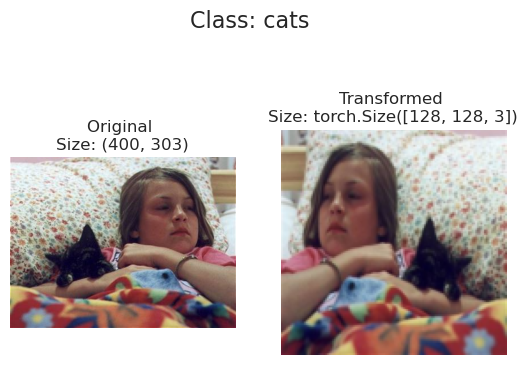

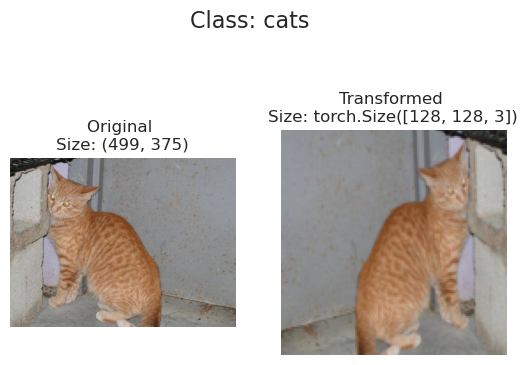

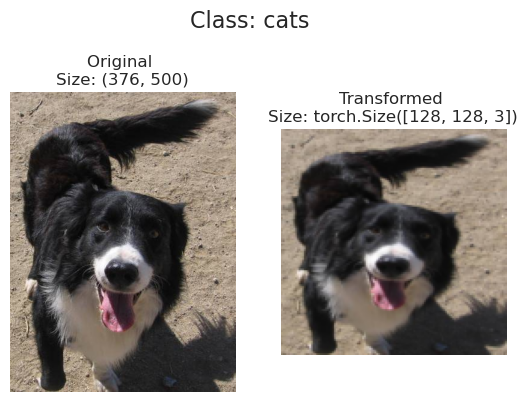

In [39]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")
            fig.suptitle(f"Class: {Path(random_image_path).parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, transform=data_transform, n=3)

Nice! we saw how to transform images. Let's go ahead and load our dataset.

<a id="Loading-image-data"></a>
# <p style="background-color:coral;font-family:newtimeroman;font-size:150%;color:white;text-align:center;border-radius:20px 20px;"><b>4. Loading Image Data</b></p>
So far, we created a data transformation function. We are ready to load our dataset using this function. The easiest way to load data is to use the `ImageFolder` function in PyTorch. Let's load the dataset with this function.

In [40]:
from torchvision import datasets

# Creating training set
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)
#Creating test set
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 8015
    Root location: dataset/training_set/training_set
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 2023
    Root location: dataset/test_set/test_set
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


Now let's discover the dataset using the attributes as shown below.

In [41]:
# Get class names as a list
class_names = train_data.classes
print("Class names: ",class_names)

# Can also get class names as a dict
class_dict = train_data.class_to_idx
print("Class names as a dict: ",class_dict)

# Check the lengths
print("The lengths of the training and test sets: ", len(train_data), len(test_data))

Class names:  ['cats', 'dogs']
Class names as a dict:  {'cats': 0, 'dogs': 1}
The lengths of the training and test sets:  8015 2023


Awesome. We learned some information about the datasets. Let's get an image and have a look at its features.

In [42]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.7882, 0.7765, 0.6196,  ..., 0.1608, 0.1608, 0.1569],
         [0.7882, 0.7529, 0.6118,  ..., 0.1490, 0.1490, 0.1529],
         [0.7882, 0.7373, 0.6118,  ..., 0.1333, 0.1333, 0.1490],
         ...,
         [0.1725, 0.2627, 0.2392,  ..., 0.0784, 0.0784, 0.0863],
         [0.1725, 0.1804, 0.2196,  ..., 0.0863, 0.0902, 0.1098],
         [0.1765, 0.1804, 0.2431,  ..., 0.0863, 0.0902, 0.1176]],

        [[0.7725, 0.7686, 0.6235,  ..., 0.1725, 0.1765, 0.1765],
         [0.7686, 0.7373, 0.6118,  ..., 0.1608, 0.1647, 0.1725],
         [0.7608, 0.7137, 0.6039,  ..., 0.1451, 0.1490, 0.1686],
         ...,
         [0.1255, 0.2078, 0.1725,  ..., 0.0706, 0.0706, 0.0784],
         [0.1255, 0.1255, 0.1569,  ..., 0.0784, 0.0824, 0.1020],
         [0.1373, 0.1255, 0.1804,  ..., 0.0784, 0.0824, 0.1098]],

        [[0.6431, 0.6706, 0.5843,  ..., 0.1922, 0.1765, 0.1608],
         [0.6510, 0.6471, 0.5804,  ..., 0.1804, 0.1647, 0.1569],
         [0.6510, 0.6392, 0.5843,  ..., 0.16

Let's visualize this image with matplotlib.

Original shape: torch.Size([3, 128, 128]) -> [color_channels, height, width]
Image permute shape: torch.Size([128, 128, 3]) -> [height, width, color_channels]


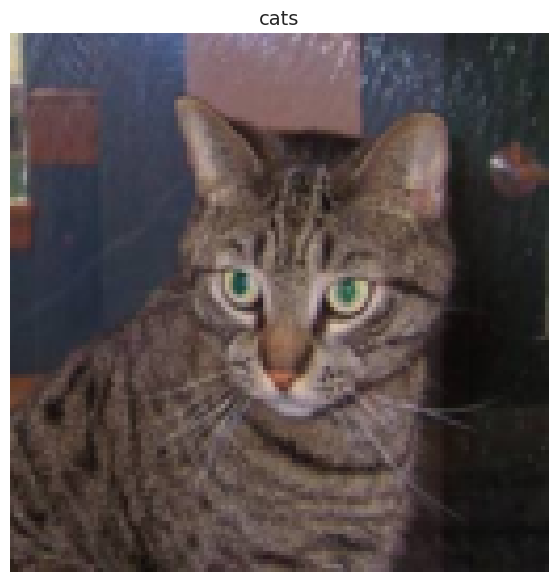

In [43]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

## Turn loaded images into DataLoader's

So far, we loaded images. Note that a `DataLoader` in PyTorch is a utility used to load data from a dataset object in parallel. It allows the user to load data in batches, which can be useful for training deep learning models, as it enables the model to process multiple samples at once, which can speed up the training process. Additionally, it also allows the user to shuffle the data, which can help to prevent overfitting.

The DataLoader takes a dataset object and several other optional parameters, such as the batch size, the number of worker threads to use for loading the data, and a boolean flag for whether or not to shuffle the data. The DataLoader will then return an iterator that can be used to iterate over the data in batches.


In [44]:
from torch.utils.data import DataLoader

# How many subprocesses will be used for data loading (higher = more)
NUM_WORKERS = os.cpu_count()

# Turn train and test Datasets into DataLoaders
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1, # how many samples per batch?
                              num_workers=NUM_WORKERS,
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=NUM_WORKERS,
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fc905335d50>,
 <torch.utils.data.dataloader.DataLoader at 0x7fc905336770>)

Nice. We turn our dataset into a `DataLoader` object. Now let's get a batch image and check the shape of this batch.

In [45]:
img, label = next(iter(train_dataloader))

# Note that batch size will now be 1.
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 128, 128]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


<a id="Model-building"></a>
# <p style="background-color:coral;font-family:newtimeroman;font-size:150%;color:white;text-align:center;border-radius:20px 20px;"><b>5. Model Building with Data Augmentation</b></p>

Have you heard of what data augmentation is? Data augmentation is a technique used to artificially increase the size of a dataset by applying random modifications to the existing data. This can help to improve the performance of deep learning models by providing the model with more diverse training examples. Data augmentation can be useful when the available dataset is small or when the model is prone to overfitting.

Some common data augmentation techniques include:

- Random flipping or rotation of images
- Random cropping of images
- Random changes to brightness, contrast or color
- Adding noise to images
- Scaling or translation of images

By using data augmentation techniques, the model can learn to generalize better and become more robust to small variations in the data. This can help to prevent overfitting and improve the model's performance on unseen data. It is important to note that data augmentation should be performed before data preprocessing. Keep in mind data augmentation should be applied only to the training set, not the validation or test set.

## 5.1 Creating transforms and loading data

TrivialAugmentWide is a data augmentation technique in PyTorch that applies random resizing and cropping to an image. The technique is intended to be used as a "wide" data augmentation technique, meaning that it makes a large number of random transformations to the image in order to increase the diversity of the training data. This can help to improve the robustness and generalization of a machine learning model. [This example](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py) illustrates the various transforms available in the torchvision.transforms module.

In [46]:
# Set image size.
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)

# Create training transform with TrivialAugment
train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor()])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()])

Now let's load our dataset with data augmentation again.

In [47]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform)
test_data_augmented = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_augmented

(Dataset ImageFolder
     Number of datapoints: 8015
     Root location: dataset/training_set/training_set
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 2023
     Root location: dataset/test_set/test_set
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

Now let's turn Datasets into DataLoader's.

In [49]:
# Set some parameters.
BATCH_SIZE = 32
torch.manual_seed(42)

train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_augmented = DataLoader(test_data_augmented,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False,
                                       num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader_augmented

(<torch.utils.data.dataloader.DataLoader at 0x7fc905337f40>,
 <torch.utils.data.dataloader.DataLoader at 0x7fc9126a2bf0>)

Nice! We created the `DataLoader` objects. Let's go ahead and build an image classification architecture.

## 5.2 Creating CNN Image Classifier

A convolutional neural network (CNN) is a type of deep learning neural network that is primarily used for image and video recognition tasks. CNNs are designed to process data that has a grid-like topology, such as an image, which is composed of pixels arranged in a 2D grid. The architecture of a CNN consists of several layers, including convolutional layers, pooling layers, and fully connected layers.

The convolutional layers are responsible for detecting features in the input image by applying a set of learnable filters to the image. These filters are convolved with the input image to produce a set of feature maps, which are then passed through pooling layers to reduce the spatial dimensions of the feature maps and retain only the most salient features. The fully connected layers then process the pooled feature maps to produce the final output, such as a classification label.

CNNs have been used to achieve state-of-the-art results on a wide range of computer vision tasks such as image classification, object detection, and semantic segmentation. Now let's go ahead and build a CNN model with nn.Module in Pytorch.

In [50]:
# # Creating a CNN-based image classifier.
class ImageClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layer_1 = nn.Sequential(
          nn.Conv2d(3, 64, 3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(64),
          nn.MaxPool2d(2))
        self.conv_layer_2 = nn.Sequential(
          nn.Conv2d(64, 512, 3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(512),
          nn.MaxPool2d(2))
        self.conv_layer_3 = nn.Sequential(
          nn.Conv2d(512, 512, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(512),
          nn.MaxPool2d(2))
        self.classifier = nn.Sequential(
          nn.Flatten(),
          nn.Linear(in_features=512*3*3, out_features=2))
    def forward(self, x: torch.Tensor):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_3(x)
        x = self.classifier(x)
        return x
# Instantiate an object.
model = ImageClassifier().to(device)

In [51]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
       BatchNorm2d-3         [-1, 64, 224, 224]             128
         MaxPool2d-4         [-1, 64, 112, 112]               0
            Conv2d-5        [-1, 512, 112, 112]         295,424
              ReLU-6        [-1, 512, 112, 112]               0
       BatchNorm2d-7        [-1, 512, 112, 112]           1,024
         MaxPool2d-8          [-1, 512, 56, 56]               0
            Conv2d-9          [-1, 512, 56, 56]       2,359,808
             ReLU-10          [-1, 512, 56, 56]               0
      BatchNorm2d-11          [-1, 512, 56, 56]           1,024
        MaxPool2d-12          [-1, 512, 28, 28]               0
           Conv2d-13          [-1, 512, 28, 28]       2,359,808
             ReLU-14          [-1, 512,

## 5.3 Try a forward pass on a single image (to test the model)

Ok, we created a CNN-based model. But does this model work? To understand this, let's pass a image through the model.

In [52]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_augmented))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model.eval()
with torch.inference_mode():
    pred = model(img_single.to(device))

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 224, 224])

Output logits:
tensor([[-0.1241, -0.0617]], device='cuda:0')

Output prediction probabilities:
tensor([[0.4844, 0.5156]], device='cuda:0')

Output prediction label:
tensor([1], device='cuda:0')

Actual label:
1


Nice! Our model is working for an image. Let's go ahead and try to understand this model.

## 5.4 Understanding the model (check & confirm)

It is important to understand the model architecture. Fortunately, there is the `torchinfo` package to see the architecture of the model. Let me show you.

In [53]:
# Install torchinfo if it's not available, import it if it is
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
# do a test pass through of an example input size
summary(model, input_size=[1, 3, IMAGE_WIDTH ,IMAGE_HEIGHT])

Layer (type:depth-idx)                   Output Shape              Param #
ImageClassifier                          [1, 2]                    --
├─Sequential: 1-1                        [1, 64, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─BatchNorm2d: 2-3                  [1, 64, 224, 224]         128
│    └─MaxPool2d: 2-4                    [1, 64, 112, 112]         --
├─Sequential: 1-2                        [1, 512, 56, 56]          --
│    └─Conv2d: 2-5                       [1, 512, 112, 112]        295,424
│    └─ReLU: 2-6                         [1, 512, 112, 112]        --
│    └─BatchNorm2d: 2-7                  [1, 512, 112, 112]        1,024
│    └─MaxPool2d: 2-8                    [1, 512, 56, 56]          --
├─Sequential: 1-3                        [1, 512, 28, 28]          --
│    └─Conv2d: 2-9                       [1, 512, 56, 56]          2,359,

## 5.5 Create train & test loop functions

Note that the model is built on the training data and tested on the validation set. Now let's create two function to train and test the model.

In [54]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [55]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

Now let's create a function named train to combine the train_step and test_step functions.

In [56]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

## 5.6 Train and Evaluate Model

So far, we created training and test steps. We are ready to train the model using these steps. Show time:

In [57]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_results = train(model=model,
                      train_dataloader=train_dataloader_augmented,
                      test_dataloader=test_dataloader_augmented,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0192 | train_acc: 0.5693 | test_loss: 0.6966 | test_acc: 0.6286
Epoch: 2 | train_loss: 0.9448 | train_acc: 0.5955 | test_loss: 0.7939 | test_acc: 0.5917
Epoch: 3 | train_loss: 0.8085 | train_acc: 0.6234 | test_loss: 0.7420 | test_acc: 0.6122
Epoch: 4 | train_loss: 0.7253 | train_acc: 0.6528 | test_loss: 1.2514 | test_acc: 0.5425
Epoch: 5 | train_loss: 0.6879 | train_acc: 0.6687 | test_loss: 1.0056 | test_acc: 0.5723
Total training time: 536.609 seconds


## 5.7 Plot the loss curves of Model

To understand the performance of model, let's visualize the loss and accuracy values.

In [58]:
def plot_loss_curves(results):

    results = dict(list(model_results.items()))

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

It is time to visualize for the loss and accuracy values using this function.

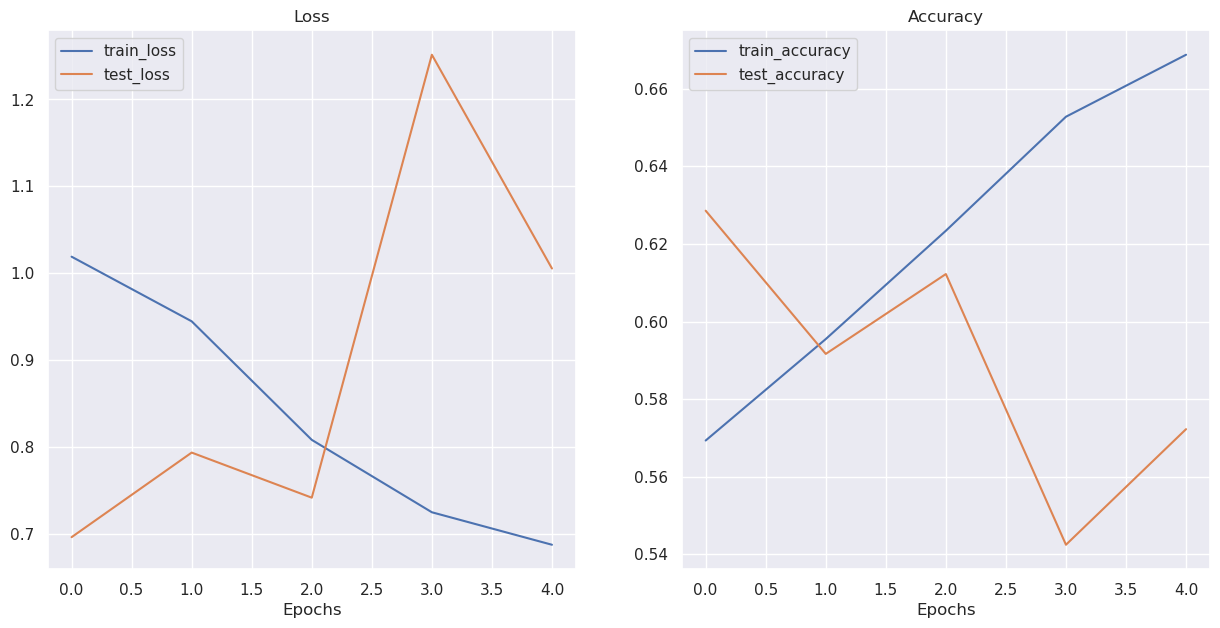

In [59]:
plot_loss_curves(model_results)

Awesome. The performance of our model is not bad on both the training and test datasets. Let's go ahead and take a look at how to make a prediction.

<a id="Prediction"></a>
# <p style="background-color:coral;font-family:newtimeroman;font-size:150%;color:white;text-align:center;border-radius:20px 20px;"><b>6. Make a Prediction</b></p>

Now we had a good model for image classification. But, how does this model predict new data? To understand this let me make a prediction on a custom image.

In [61]:
# Choose a image.
custom_image_path = "dataset-card.jpeg"

import torchvision
# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255.

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

Custom image shape: torch.Size([3, 1200, 1200])

Custom image dtype: torch.float32


Now let's create transform pipleine to resize image.

In [62]:
custom_image_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 1200, 1200])
New shape: torch.Size([3, 224, 224])


First, let's fit the image for the model with the function we created and then make a prediction.

In [63]:
model.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)

    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")

    # Make a prediction on image with an extra dimension
    custom_image_pred = model(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 224, 224])
Unsqueezed custom image shape: torch.Size([1, 3, 224, 224])


Now let's take a look at our model's predictions.

In [64]:
custom_image_pred

tensor([[-2.7358,  1.7249]], device='cuda:0')

Nice! we've seen the prediction values of the model. Let's take a look at the prediction class. First, let me show you the prediction values.

In [65]:
# Let's convert them from logits -> prediction probabilities -> prediction labels
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[-2.7358,  1.7249]], device='cuda:0')
Prediction probabilities: tensor([[0.0114, 0.9886]], device='cuda:0')
Prediction label: tensor([1], device='cuda:0')


It is time to find the predicted label.

In [66]:
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
custom_image_pred_class

'dogs'

Let's visualize this image with matplotlib.

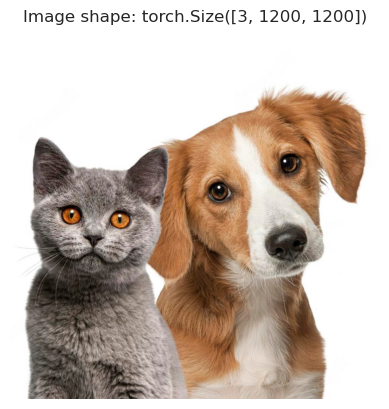

In [67]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

# Interpretating the Results

### 📉 **Loss Curve:**
- **Decreasing Loss:** A decreasing training loss curve indicates that your model is learning the underlying patterns of the dataset effectively.
- **Watch for Overfitting:** If your validation (or test) loss stops decreasing or starts increasing while your training loss continues to decline, this may indicate overfitting. Overfitting means your model memorizes training examples instead of learning generalized features.

### 📈 **Accuracy Curve:**
- **Improving Accuracy:** Ideally, both your training and validation accuracy curves should gradually increase and stabilize at a high level. This indicates effective learning and good performance.
- **Overfitting Indicator:** If there’s a large gap between training and validation accuracy (e.g., high training accuracy and significantly lower validation accuracy), it suggests the model struggles to generalize and is likely overfitting.

### 🎯 **Prediction Confidence:**
- Your model outputs predictions as raw values called logits. By applying the softmax function, these logits convert into probabilities:
  - **High confidence (probabilities close to 1)** indicates strong certainty about predictions.
  - **Low confidence (probabilities near 0.5)** means your model is unsure, reflecting difficulty distinguishing between classes.

### 🔍 **Visual Checks:**
- Always visually inspect predictions by plotting actual images alongside their predicted classes. Visual inspection helps you intuitively understand your model's performance and identify potential reasons for misclassification.

### 🖼️ **Testing with Custom Images:**
- Testing your model with new, unseen images allows you to evaluate how well the model generalizes. Compare the predicted label and probability against the actual image to validate practical performance.

### 🚦 **Next Steps for Improvement:**
- If the model is overfitting, consider:
  - Increasing data augmentation.
  - Using regularization techniques (e.g., dropout).
  - Adjusting your CNN architecture or training hyperparameters (like learning rate, epochs, or batch size).


# Conclusion

In this notebook, you learned how to build an image classification model from scratch with Pytorch. Tensorflow is generally preferred for deep learning projects. However, with Pytorch you can better control the deep-learning analysis steps. Pytorch has been preferred more recently, especially in the academic community. we also talked about data augmentation and highlighted the importance of this technique.

# Resources

- [Learn Pytorch](https://www.learnpytorch.io/)
- [Modern Computer Vision with PyTorch](https://www.amazon.com/Modern-Computer-Vision-PyTorch-applications/dp/1839213477)
